**Michael Bochynski** <br>
URSP688Y: Urban Data Science & Smart Cities<br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
University of Maryland, College Park <br>
April 28, 2025

# Exercise04 - Michael

## 1. Research Question
**To what extent are properties near the College Park and Greenbelt transit stations underutilized based on current zoning regulations, and how can zoning regulations be adjusted to optimize land use for higher-density residential development?**

## 2. Approach Outline

- Load property, zoning, buffer, and boundary shapefiles
- Filter properties located within 1 mile of either College Park or Greenbelt station
- Merge property data with zoning data
- Calculate allowed residential density (units per acre) based on zoning
- Calculate built residential density (existing units per acre) based on property data
- Compare built density to allowed density to identify underutilized parcels
- Summarize number, proportion, and characteristics of underutilized parcels

## 3. Load Packages

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

## 4. Load Data

In [25]:
# Load the datasets
property_gdf = gpd.read_file('data/Property_Info_Py.shp')  # Property Info dataset
zoning_data = gpd.read_file('data/Clean_Zoning_Py.gpkg')    # Zoning Data
metro_buffer = gpd.read_file('data/Metro_One_Mile_Buffer_Py.shp')  # Metro Buffer
muni_boundary = gpd.read_file('data/Municipal_Boundary_Py.shp') # Municipal Boundary

C:\Users\mboch\miniconda3\envs\688y\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
C:\Users\mboch\miniconda3\envs\688y\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Geometry of polygon of fid 6 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(


## 5. Data Preparation

In [26]:
# Ensure CRS consistency (WGS84 for everything)
crs_epsg = 4326
property_gdf = property_gdf.to_crs(epsg=crs_epsg)
zoning_data = zoning_data.to_crs(epsg=crs_epsg)
metro_buffer = metro_buffer.to_crs(epsg=crs_epsg)
muni_boundary = muni_boundary.to_crs(epsg=crs_epsg)

# Filter to College Park boundary
college_park_boundary = muni_boundary[muni_boundary['CITY'] == 'College Park']
college_park_boundary = college_park_boundary.unary_union  # ensure single geometry

# Filter property parcels inside College Park boundary
property_gdf = property_gdf[property_gdf.geometry.within(college_park_boundary)]

# Filter parcels within 1 mile of Metro stations
metro_union = metro_buffer.geometry.unary_union
property_gdf = property_gdf[property_gdf.geometry.within(metro_union)]

C:\Users\mboch\AppData\Local\Temp\ipykernel_29300\4271488982.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  college_park_boundary = college_park_boundary.unary_union  # ensure single geometry
C:\Users\mboch\AppData\Local\Temp\ipykernel_29300\4271488982.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  metro_union = metro_buffer.geometry.unary_union


## 6. Density Calculations

In [29]:
# Allowable densities (units/acre) sourced from PG County Zoning Ordinance (EncodePlus)
zoning_rules = {
    'RE': 1.08,    # 1.08 units per acre
    'RR': 2.17,    # 2.17 units per acre
    'RSF-95': 4.58,
    'RSF-65': 6.7,
    'RSF-A': 16.33,
    'RMF-12': 24,
    'RMF-20': 40,
    'RMF-48': 48
}

# Map zoning to allowed density
property_gdf['allowed_density'] = property_gdf['ZONE_1'].map(zoning_rules)

# Drop rows with missing allowed_density (zones not found in zoning_rules)
property_gdf.dropna(subset=['allowed_density'], inplace=True)

# Calculate built density (units per acre)
property_gdf['built_density'] = property_gdf['DUS'] / property_gdf['ACRES']

# Calculate underutilization ratio
property_gdf['underutilization_ratio'] = property_gdf['built_density'] / property_gdf['allowed_density']

## 7. Identify Underutilized Parcels

Number of underutilized parcels: 375
Total parcels analyzed: 3023
Percentage underutilized: 12.40%
Average underutilization ratio (for underutilized parcels): 0.23
       ACCT_PRIMA  ZONE_1  allowed_density  built_density  \
362       0004739  RSF-65             6.70       0.000000   
1764      0025429  RSF-65             6.70       3.125000   
1828      0018614      RR             2.17       0.000000   
3546      0031914  RSF-65             6.70       3.333333   
189728    2128098  RSF-65             6.70       0.000000   

        underutilization_ratio  
362                   0.000000  
1764                  0.466418  
1828                  0.000000  
3546                  0.497512  
189728                0.000000  


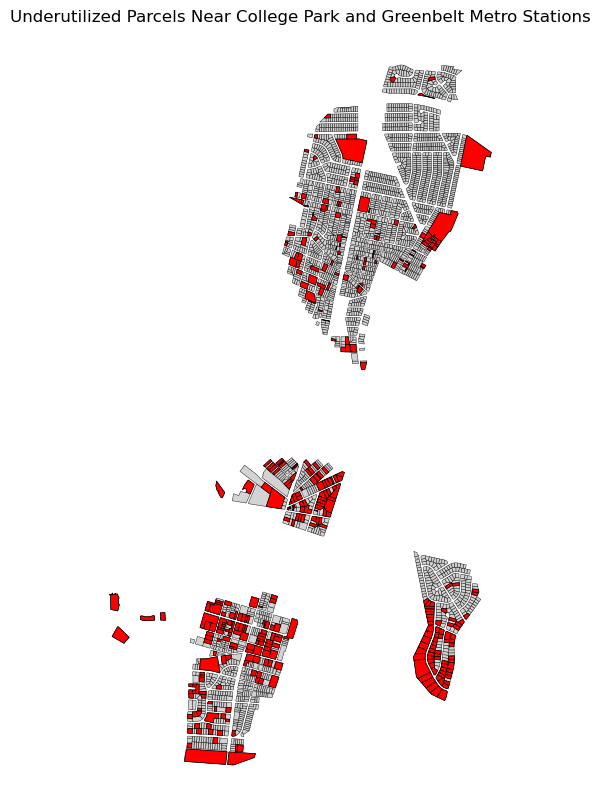

In [31]:
# Flag parcels that are underutilized (e.g., built less than 50% of allowed density)
underutilized_threshold = 0.5
property_gdf['underutilized'] = property_gdf['underutilization_ratio'] < underutilized_threshold

# Select underutilized parcels
underutilized_parcels = property_gdf[property_gdf['underutilized']]

# Output basic statistics
num_underutilized = underutilized_parcels.shape[0]
total_parcels = property_gdf.shape[0]
percent_underutilized = (num_underutilized / total_parcels) * 100
avg_underutilization_ratio = underutilized_parcels['underutilization_ratio'].mean()

print(f'Number of underutilized parcels: {num_underutilized}')
print(f'Total parcels analyzed: {total_parcels}')
print(f'Percentage underutilized: {percent_underutilized:.2f}%')
print(f'Average underutilization ratio (for underutilized parcels): {avg_underutilization_ratio:.2f}')

# Preview a few underutilized parcels
print(underutilized_parcels[['ACCT_PRIMA', 'ZONE_1', 'allowed_density', 'built_density', 'underutilization_ratio']].head())

# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all parcels
property_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.3)

# Highlight underutilized parcels
underutilized_parcels.plot(ax=ax, color='red', edgecolor='black', linewidth=0.5)

# Set plot title and remove axes
plt.title('Underutilized Parcels Near College Park and Greenbelt Metro Stations')
plt.axis('off')
plt.show()

## 8. Preliminary Analysis
This preliminary analysis assessed the extent of residential underutilization across selected parcels in Prince George’s County. By comparing current built residential densities to the maximum allowable densities under existing zoning regulations, we found that approximately 12.4% of parcels exhibit significant underutilization. These parcels have, on average, achieved only 23% of their permitted density.

These findings suggest a measurable opportunity for infill development or rezoning efforts to encourage higher-density residential growth, particularly near existing infrastructure. Future steps will involve refining the underutilization thresholds, conducting a spatial analysis relative to transit accessibility, and identifying potential policy interventions to better align built form with zoning intent.

## 9. Next Steps
- Refine zoning density assumptions (different zones might allow different densities beyond simple lookup).
- Map underutilized parcels for visualization.
- Explore policy options for adjusting zoning to allow more residential development.

## 10. Data Sources and References
- Property and Zoning Shapefiles: <br>
Retrieved from Prince George’s County GIS Open Data Portal:
[https://gisdata.pgplanning.org/opendata/]

- Zoning Allowable Density Standards: <br>
Retrieved from the Prince George’s County Zoning Ordinance:
[https://online.encodeplus.com/regs/princegeorgescounty-md/doc-viewer.aspx#secid-634]

# Notes
- All data files must be placed in the data/ directory.
- Be sure to install necessary Python packages before running the notebook.